##Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files

##Constants

In [11]:
IMG_HEIGHT, IMG_WIDTH = 96, 128
BATCH_SIZE = 32
SEED = 42
CLASS_NAMES = [f'c{i}' for i in range(10)]

##Data Loading

In [12]:
# Upload Kaggle key and download data
files.upload()  # select kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle competitions download -c state-farm-distracted-driver-detection -p ./data
!unzip -q -o ./data/state-farm-distracted-driver-detection.zip -d ./data

# Locate the actual train directory
root = Path('./data')
# Find folder named 'train' under any 'imgs' folder
candidates = list(root.rglob('imgs/train'))
if not candidates:
    raise FileNotFoundError("Couldn't find imgs/train under ./data")
data_dir = str(candidates[0])
print("Using data_dir =", data_dir)


Saving kaggle.json to kaggle.json
^C
Using data_dir = data/imgs/train


##Data Preparation

In [9]:
# Initial split: 15% as a test the rest 85% for training
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.15,
    subset='training',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.15,
    subset='validation',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Within that 85%, take 10% for validation and the rest for training
total = tf.data.experimental.cardinality(train_val_ds).numpy()
n_val = int(total * 0.10)
val_ds   = train_val_ds.take(n_val)
train_ds = train_val_ds.skip(n_val)

# Normalize on the fly & optimize I/O
def normalize(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(normalize,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

# Check CSV
df = pd.read_csv('data/driver_imgs_list.csv')
display(df['classname'].value_counts())

Found 22424 files belonging to 10 classes.
Using 19061 files for training.
Found 22424 files belonging to 10 classes.
Using 3363 files for validation.


,count
classname,
c0,2489
c3,2346
c4,2326
c6,2325
c2,2317
c5,2312
c1,2267
c9,2129
c7,2002


##Build CNN Model

In [5]:
def build_model_cfg(cfg, h, w):
    model = Sequential()
    for i, (filt, k) in enumerate(zip(cfg['filters'], cfg['kernels'])):
        if i == 0:
            model.add(Conv2D(filt, (k, k), activation='relu',
                             padding='same', input_shape=(h, w, 3)))
        else:
            act = 'relu' if i % 2 == 0 else 'elu'
            model.add(Conv2D(filt, (k, k), activation=act, padding='same'))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=cfg['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##Train Model

In [6]:
configs = [
    {'filters':[32,64,128,256], 'kernels':[4,4,1,1], 'lr':0.001},
    {'filters':[16,32,64,128], 'kernels':[1,2,2,1], 'lr':0.0005},
    {'filters':[16,32,64,128,256],  'kernels':[2,3,4,3,6], 'lr':0.04},
]

# Train and track best model
best_val_acc = 0.0
best_model = None
best_cfg_key = None

for cfg in configs:
    tf.keras.backend.clear_session()
    model = build_model_cfg(cfg, IMG_HEIGHT, IMG_WIDTH)
    history = model.fit(train_ds,
                        epochs=7,
                        validation_data=val_ds,
                        verbose=1)
    val_acc = max(history.history['val_accuracy'])
    key = f"filters={cfg['filters']}, kernels={cfg['kernels']}, lr={cfg['lr']}"
    print(f"{key} → best val_acc = {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_cfg_key = key

print(f"\nBest configuration: {best_cfg_key} with val_acc={best_val_acc:.4f}")

Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


537/537 ━━━━━━━━━━━━━━━━━━━━ 530s 967ms/step - accuracy: 0.3943 - loss: 1.6609 - val_accuracy: 0.9608 - val_loss: 0.1746
Epoch 2/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 473s 881ms/step - accuracy: 0.9364 - loss: 0.2090 - val_accuracy: 0.9783 - val_loss: 0.0688
Epoch 3/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 470s 875ms/step - accuracy: 0.9694 - loss: 0.1033 - val_accuracy: 0.9894 - val_loss: 0.0379
Epoch 4/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 476s 886ms/step - accuracy: 0.9816 - loss: 0.0615 - val_accuracy: 0.9889 - val_loss: 0.0317
Epoch 5/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 498s 879ms/step - accuracy: 0.9787 - loss: 0.0630 - val_accuracy: 0.9921 - val_loss: 0.0360
Epoch 6/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 469s 874ms/step - accuracy: 0.9835 - loss: 0.0545 - val_accuracy: 0.9921 - val_loss: 0.0299
Epoch 7/7
537/537 ━━━━━━━━━━━━━━━━━━━━ 477s 888ms/step - accuracy: 0.9839 - loss: 0.0496 - val_accuracy: 0.9878 - val_loss: 0.0572
filters=[32, 64, 128, 256], kernels=[4, 4, 1, 1], lr=0.001 → best val_acc = 0.9921
Epoch 1/7


##Evaluate with Confusion Matrix and Classification Report

106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9906 - loss: 0.0347
Test accuracy: 0.9911


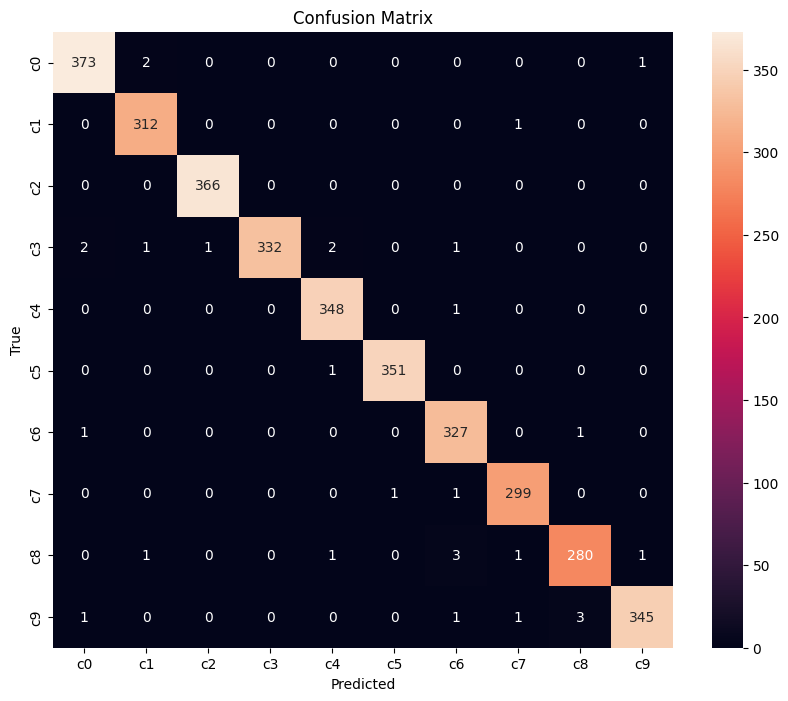


Classification Report:
               precision    recall  f1-score   support

          c0       0.99      0.99      0.99       376
          c1       0.99      1.00      0.99       313
          c2       1.00      1.00      1.00       366
          c3       1.00      0.98      0.99       339
          c4       0.99      1.00      0.99       349
          c5       1.00      1.00      1.00       352
          c6       0.98      0.99      0.99       329
          c7       0.99      0.99      0.99       301
          c8       0.99      0.98      0.98       287
          c9       0.99      0.98      0.99       351

    accuracy                           0.99      3363
   macro avg       0.99      0.99      0.99      3363
weighted avg       0.99      0.99      0.99      3363



In [7]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Confusion matrix on full test set
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = best_model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=CLASS_NAMES))

##Show Top-3 Prediction

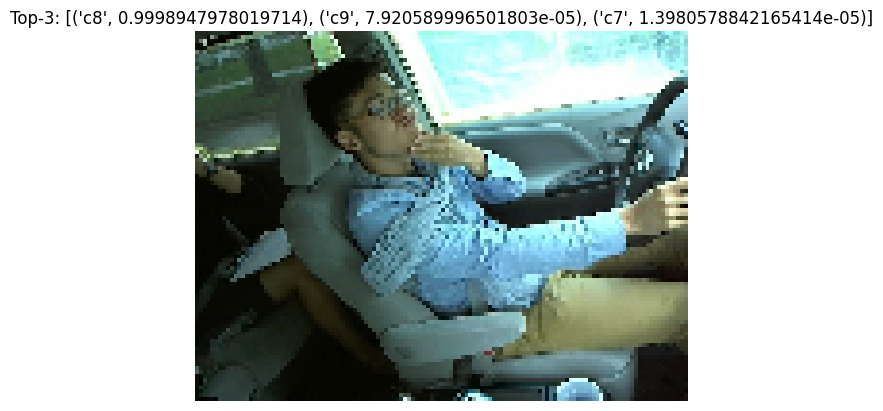

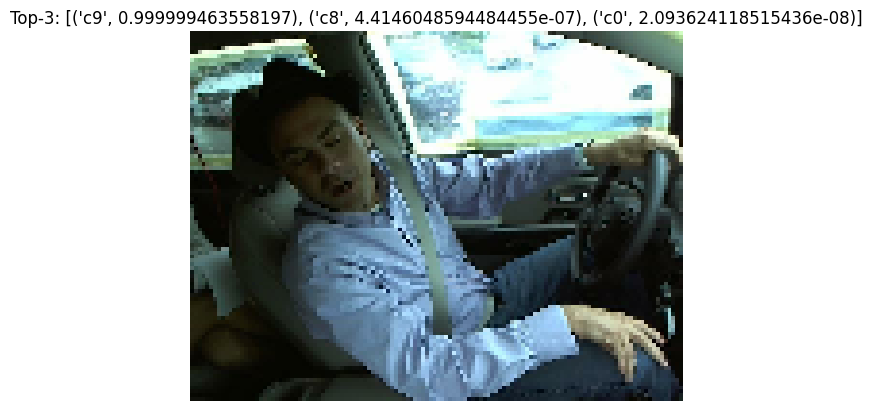

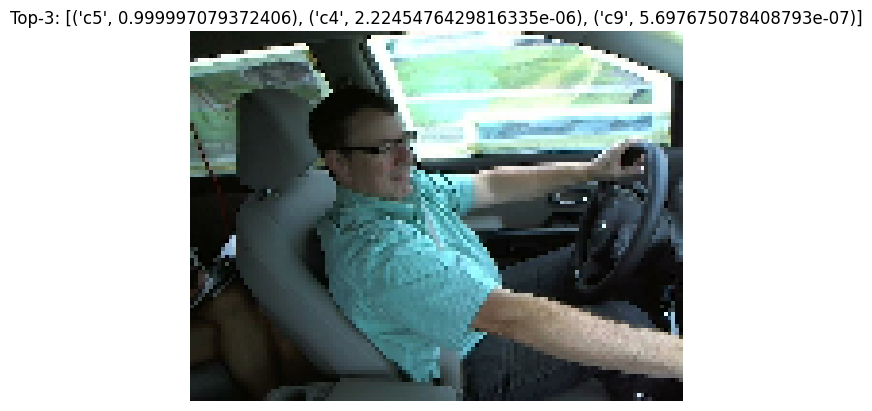

In [8]:
# Show Top-3 predictions for a sample batch
norm_batch, _ = next(iter(test_ds))
# Predict probabilities
batch_probs = best_model.predict(norm_batch, verbose=0)

def show_top3(images, probs, names, n=5):
    for i in range(n):
        # Denormalize back to [0,255] uint8 for correct plotting
        img = (images[i] * 255).numpy().astype('uint8')
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        # Get top 3 class indices in descending order of probability
        top3_idx = np.argsort(probs[i])[-3:][::-1]
        # Map to (class_name, probability)
        top3 = [(names[j], float(probs[i][j])) for j in top3_idx]
        plt.title(f"Top-3: {top3}")
        plt.show()

# Display the first 3 examples from that batch
show_top3(norm_batch, batch_probs, CLASS_NAMES, n=3)